In [1]:
import os

from utils import get_dataset, read_paths, pickle_data, unpickle_data
from desc_calculators import compute_fg_2D_pharm, compute_fg_2D_topo, compute_fg_MACCS, compute_fg_morgan

reload = True
fingerprinter = compute_fg_2D_pharm

data_antidecoys = None
data_bidirectional = None
if not os.path.exists('data_antidecoys.pickle') or reload:
    print('Creating dataset. This may take a while...')
    data_antidecoys = get_dataset(read_paths('antidecoys_data/paths.pickle'), fingerprinter)
    data_bidirectional = get_dataset(read_paths('bidirectional_data/paths.pickle'), fingerprinter)
    data_antidecoys.insert(1, 'Type', [1] * data_antidecoys.shape[0])
    data_bidirectional.insert(1, 'Type', [0] * data_bidirectional.shape[0])
    pickle_data(data_antidecoys, 'data_antidecoys.pickle')
    pickle_data(data_bidirectional, 'data_bidirectional.pickle')
else:
    print('Loading precomputed data...')
    data_antidecoys = unpickle_data('data_antidecoys.pickle')
    data_bidirectional = unpickle_data('data_bidirectional.pickle')

data_antidecoys.shape, data_bidirectional.shape

Creating dataset. This may take a while...


((1028, 3350), (1147, 3350))

In [2]:
import pandas as pd

data = pd.concat([data_antidecoys, data_bidirectional], axis=0)

In [3]:
from sklearn.metrics.pairwise import pairwise_distances

dist_matrix_anti = None
dist_matrix_bi = None
if not os.path.exists('dist_matrix_anti.pickle') or reload:
    dist_matrix_anti = pairwise_distances(data[data['Type'] == 1].iloc[:,2:], metric='jaccard', n_jobs=2)
    dist_matrix_bi = pairwise_distances(data[data['Type'] == 0].iloc[:,2:], metric='jaccard', n_jobs=2)
    pickle_data(dist_matrix_anti, 'dist_matrix_anti.pickle')
    pickle_data(dist_matrix_bi, 'dist_matrix_bi.pickle')
else:
    print('Loading precomputed distance data...')
    dist_matrix_anti = unpickle_data('dist_matrix_anti.pickle')
    dist_matrix_bi = unpickle_data('dist_matrix_bi.pickle')
dist_matrix_anti.shape, dist_matrix_bi.shape

/home/sichom/software/miniconda/envs/antidecoys-analysis/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/sichom/software/miniconda/envs/antidecoys-analysis/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/sichom/software/miniconda/envs/antidecoys-analysis/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the F

((1028, 1028), (1147, 1147))

In [4]:
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

def get_distances(dist_matrix):
    values = numpy.array([])
    for i in range(1, dist_matrix.shape[0]):
        values = numpy.append(values, dist_matrix.diagonal(-i))
    weights = numpy.ones_like(values)/len(values)
    return values, weights

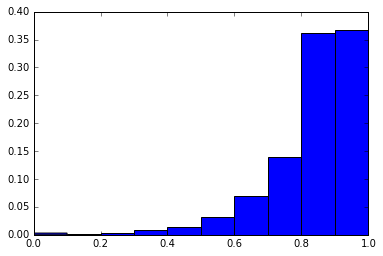

In [5]:
vals, weights = get_distances(dist_matrix_anti)
plt.hist(vals, weights=weights)
plt.show()

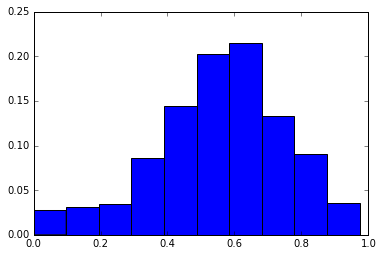

In [6]:
vals, weights = get_distances(dist_matrix_bi)
plt.hist(vals, weights=weights)
plt.show()

In [7]:
def avg_dist(dist_matrix):
    return dist_matrix.sum() / (dist_matrix.shape[0]**2 - dist_matrix.shape[0])

avg_dist(dist_matrix_anti), avg_dist(dist_matrix_bi)

(0.83265188996572936, 0.55666878718433421)

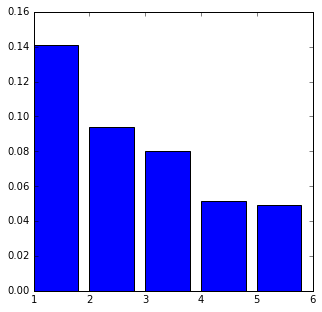

In [8]:
from utils import do_PCA, plot_eigenvalues

pca_data, eigvals = do_PCA(data.iloc[:,2:])
plot_eigenvalues(eigvals)

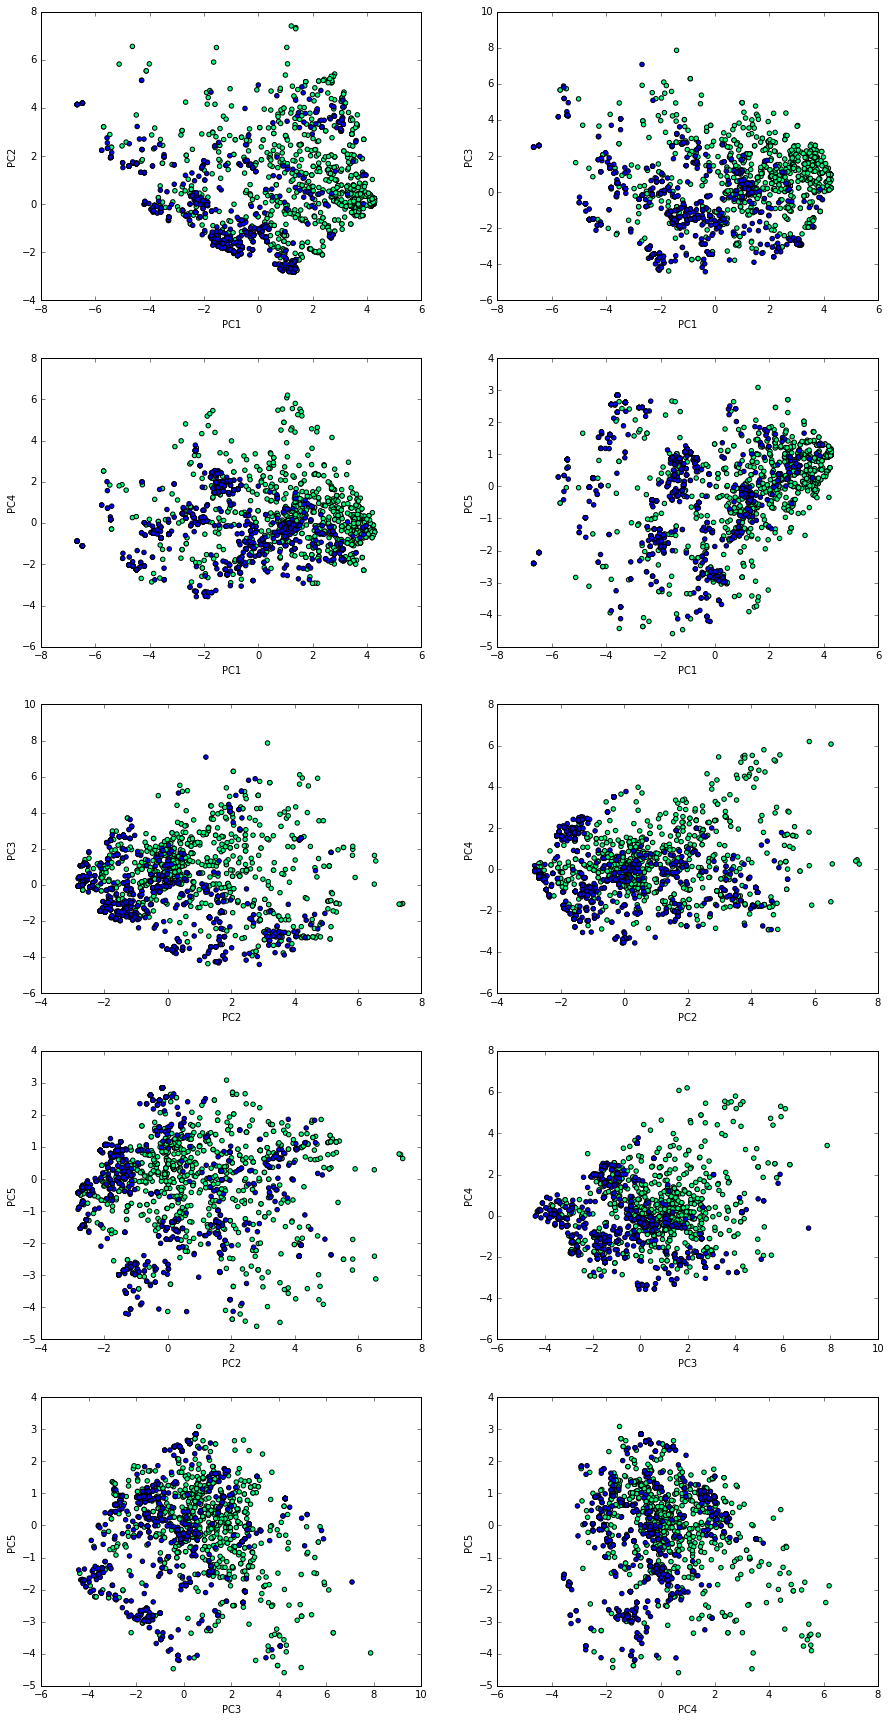

In [9]:
from utils import plot_PCA_2D, plot_PCA_3D

plot_function = plot_PCA_2D

plot_function(pca_data, data.Type)

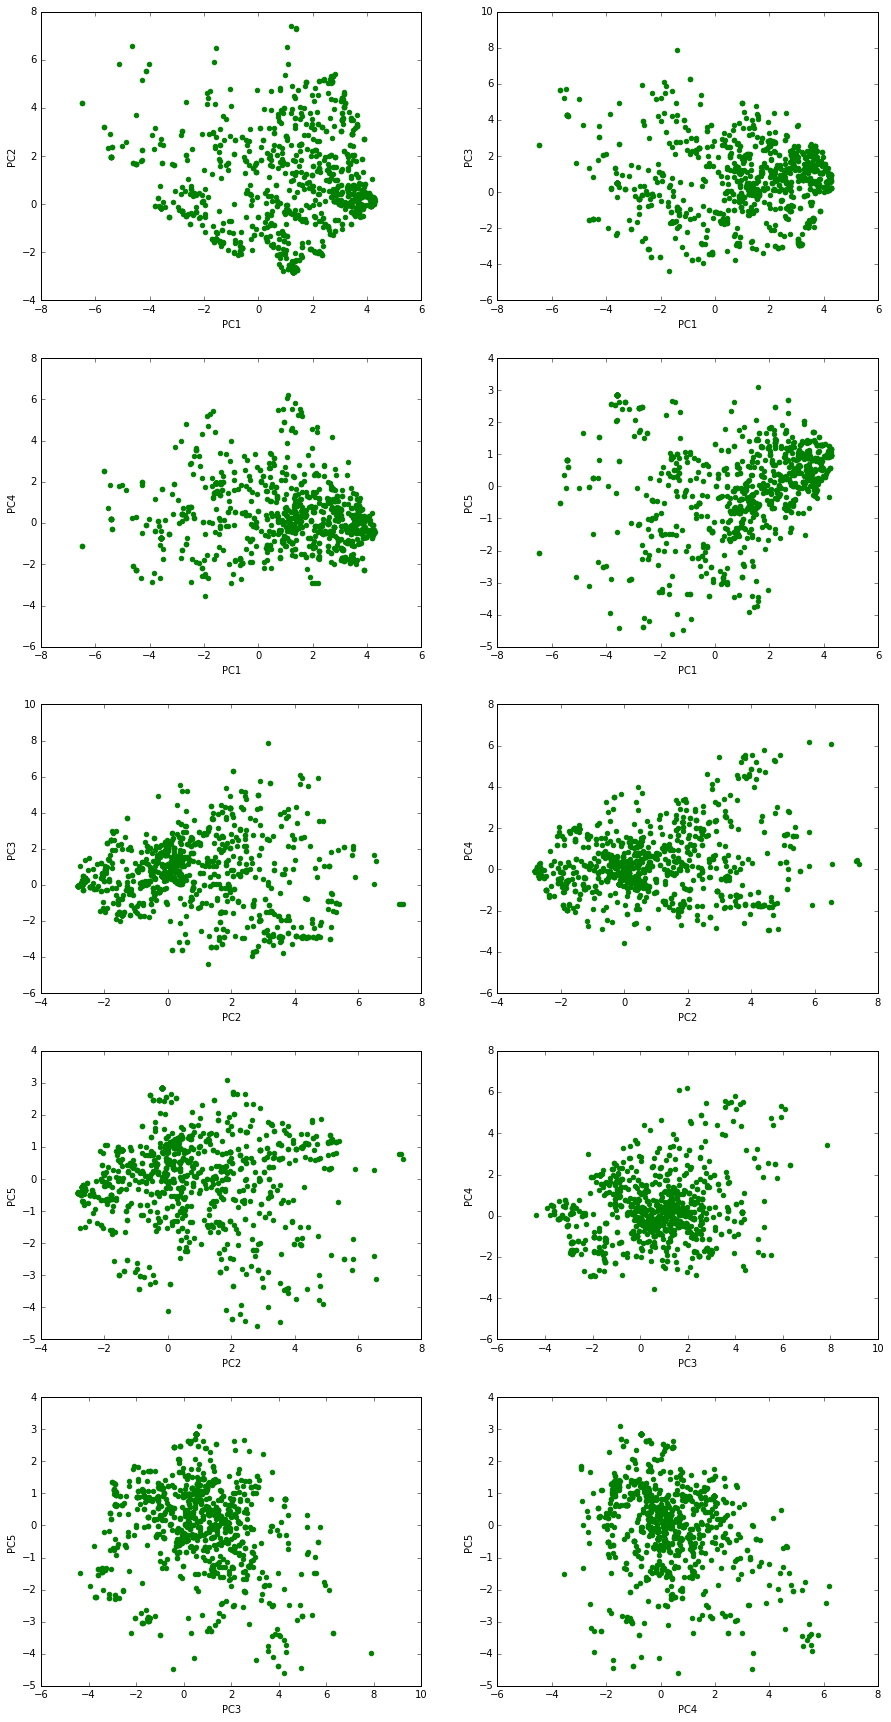

In [10]:
mask = numpy.array(data['Type'] == 1) # only those generated using antidecoys
plot_function(pca_data[mask], color='green')

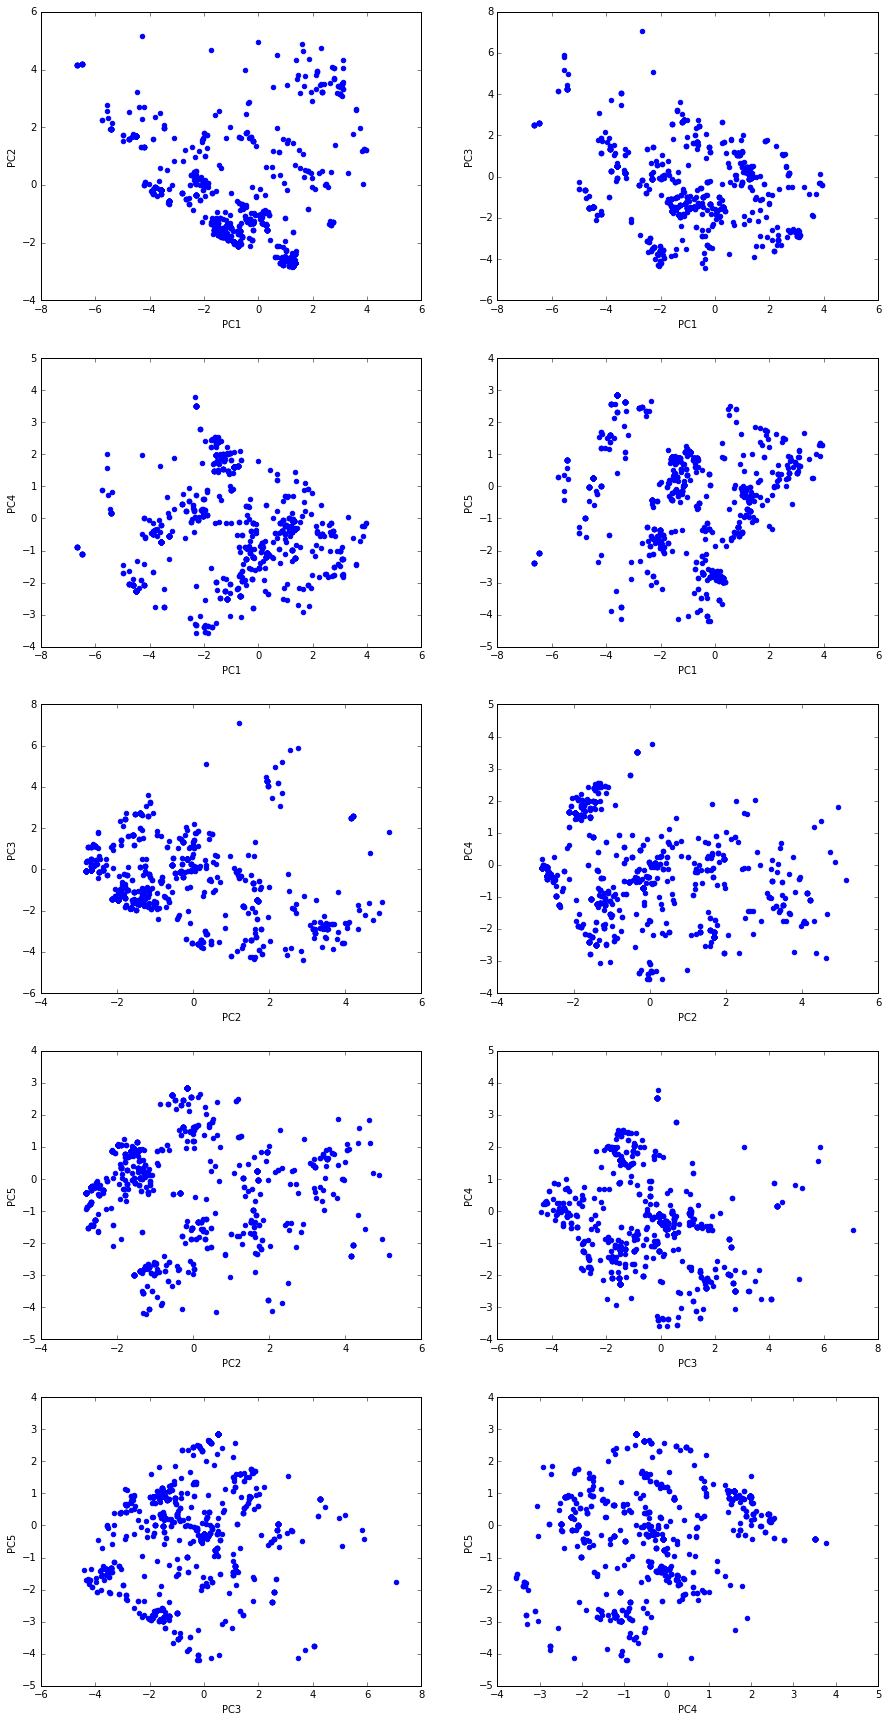

In [11]:
mask = numpy.array(data['Type'] == 0) # only those generated using bidirectional search

plot_function(pca_data[mask], color='blue')

In [12]:
paths_anti = read_paths('antidecoys_data/paths.pickle', ignore_failed=False)
paths_bi = read_paths('bidirectional_data/paths.pickle', ignore_failed=False)
print('Paths found (antidecoys):', '{0}/{1}'.format(len([x for x in paths_anti if x]), len(paths_anti)))
print('Paths found (bidirectional):', '{0}/{1}'.format(len([x for x in paths_bi if x]), len(paths_bi)))

Paths found (antidecoys): 44/44
Paths found (bidirectional): 100/100


In [13]:
def get_unique_mols(paths):
    mols = set()
    for path in paths:
        if path:
            mols.update(path[1:-1])
    return mols

unique_mols_anti = get_unique_mols(paths_anti)
unique_mols_bi = get_unique_mols(paths_bi)

print('Unique molecules (antidecoys):', len(unique_mols_anti))
print('Unique molecules (bidirectional):', len(unique_mols_bi))

Unique molecules (antidecoys): 966
Unique molecules (bidirectional): 774


In [14]:
from pandas import DataFrame

def count_hits(paths):
    mols = dict()
    for path in paths:
        if path:
            for mol in path[1:-1]:
                if mol not in mols:
                    mols[mol] = 1
                else:
                    mols[mol] += 1
    return mols

def top_hits(hits, top=10):
    return [(key, value) for (key, value) in sorted(hits.items(), key=lambda x : x[1] , reverse=True)][:top]

hits_anti = count_hits(paths_anti)
hits_bi = count_hits(paths_bi)

print('Top 10 most hit (antidecoys):')
print(DataFrame(top_hits(hits_anti), columns=['SMILES', 'Count']))
print('Top 10 most hit (bidirectional):')
print(DataFrame(top_hits(hits_bi), columns=['SMILES', 'Count']))

Top 10 most hit (antidecoys):
                                    SMILES  Count
0    COC(=O)CC1CCC(CCOC(=O)C2=CC=CC=C2)N1C     14
1               CCN(CC)CCOC(=O)C1=CC=CC=C1      7
2  COC(=O)C(COC(=O)C1=CC=CC=C1)C1CCC(C)N1C      6
3  COC(=O)C(C(C)OC(=O)C1=CC=CC=C1)C1CCCN1C      5
4    COC(=O)CC(CC1CCCN1C)OC(=O)C1=CC=CC=C1      5
5    CNC1CCCCC(OC(=O)C2=CC=CC=C2)C1C(=O)OC      4
6         CCN(CCOC(=O)C1=CC=C(N)C=C1)C(C)C      4
7  CCC1C(C(=O)OC)C(OC(=O)C2=CC=CC=C2)CCN1C      3
8   CC1CCC(C(COC(=O)C2=CC=CC=C2)C(=O)O)N1C      3
9          CCN1CCC(OC(=O)C2=CC=C(N)C=C2)C1      3
Top 10 most hit (bidirectional):
                                    SMILES  Count
0               CCN(CC)CCOC(=O)C1=CC=CC=C1     31
1  CCC1C(C(=O)OC)C(OC(=O)C2=CC=CC=C2)CCN1C     28
2    COC(=O)CC1CCC(CCOC(=O)C2=CC=CC=C2)N1C     21
3  CCC1CC(OC(=O)C2=CC=CC=C2)C(C(=O)OC)CN1C     14
4  COC(=O)C(COC(=O)C1=CC=CC=C1)C1CCC(C)N1C     13
5   COC(=O)C1C(C)N(C)CCC1OC(=O)C1=CC=CC=C1      9
6           CCC(C)N(C)CCCOC(=O)C1=CC=